08/20/2020

MM Vocab Finder

In [1]:
# basic packages
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import itertools
from collections import Counter, defaultdict
import time
# Import tools needed for visualization
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt

In [2]:
save_dir = '../data/processed/fig4_modelling/vocab_sum/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [3]:
TISSUE = 'MM'

In [4]:
MAX_DIST=135


In [6]:
#get tfs
tf_df = pd.read_csv('../data/external/transcription_factor_info_063020.csv')
TFS = sorted(set(tf_df[tf_df['cell_type']=='Melanocytes']["tf"]))##### DIFFERENT FOR EACH TISSUE
TFS = sorted(set(TFS+['CPEB1','KLF9','TBX3','TCF4','GATA1','STAT1','SP1','PSG1']))
print(len(TFS))
print(TFS)


36
['ATF4', 'CERS2', 'CPEB1', 'CSDE1', 'EDF1', 'EIF3K', 'ETS1', 'EWSR1', 'GATA1', 'H1F0', 'HMG20B', 'HMGB1', 'IFI16', 'IRF4', 'KLF9', 'LEF1', 'MITF', 'NFE2L1', 'PAX3', 'PHB2', 'PLXNC1', 'PSG1', 'RB1', 'SNAI2', 'SOX10', 'SP1', 'SREBF2', 'STAT1', 'TBX3', 'TCEAL8', 'TCF4', 'TFAP2A', 'USF2', 'YBX1', 'YY1', 'ZFP106']


In [7]:
vocab_dir = '../data/processed/fig4_modelling/tf_tf_pairs/'

read in loop_types

In [8]:
glob.glob('../data/processed/fig4_modelling/tf_tf_pairs_mm/'+'*loop_type*')

['../data/processed/fig4_modelling/tf_tf_pairs_mm/expr_WM-SCR-DMSO_loop_type.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_mm/expr_COLO-SCR-DMSO_loop_type.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_mm/diff_WM-SCR-DMSO_loop_type.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_mm/diff_COLO-SCR-DMSO_loop_type.csv']

# 1 understand the types of vocabularies pulled out and where they come from

## 1A. enriched vocabularies from unique tissue genes

In [24]:
loop_type_df_1 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_mm/diff_WM-SCR-DMSO_loop_type.csv',index_col=0).fillna('')
loop_type_df_2 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_mm/diff_COLO-SCR-DMSO_loop_type.csv',index_col=0).fillna('')


In [25]:
loop_type_df_all = loop_type_df_1[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]+loop_type_df_2[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]
loop_type_df_all['pro_loop_count'] = loop_type_df_all['pro_loop_count']+ loop_type_df_all['loop_pro_count']
loop_type_df_all = loop_type_df_all[['pro_pro_count','pro_loop_count','loop_loop_count']]
loop_type_df_all[:5]

,pro_pro_count,pro_loop_count,loop_loop_count
ARID3A::ARID5B,6,34,276
ARID3A::BHLHE40,0,0,24
ARID3A::DLX1,1,4,77
ARID3A::DLX2,2,7,133
ARID3A::EGR2,0,9,136


In [26]:
# for motifs
# 1. get motifs
motifs = set()
for vocab_pair in loop_type_df_all.index.values:
    v1, v2 = vocab_pair.split('::')
    motifs.add(v1)
    motifs.add(v2)
motifs = sorted(motifs)
print(len(motifs))

# 2. initialize counts
motif_counts_dict = {}
for motif in motifs:
    motif_counts_dict[motif] = {'pro_pro_count':0,'loop_loop_count':0,'pro_loop_count':0} #list of counts for pro_pro_count, loop_loop_count, pro_loop_count, respectively
    
# 3. run through loop_type_df to fill in motif_counts_dict
for vocab_pair, row in loop_type_df_all.iterrows():
    v1, v2 = vocab_pair.split('::')
    motif_counts_dict[v1]['pro_pro_count'] +=row['pro_pro_count']
    motif_counts_dict[v2]['pro_pro_count'] +=row['pro_pro_count']
    motif_counts_dict[v1]['loop_loop_count'] +=row['loop_loop_count']
    motif_counts_dict[v2]['loop_loop_count'] +=row['loop_loop_count']
    motif_counts_dict[v1]['pro_loop_count'] +=row['pro_loop_count']
    motif_counts_dict[v2]['pro_loop_count'] +=row['pro_loop_count']
            
motif_counts_df = pd.DataFrame.from_dict(motif_counts_dict,orient='index')   
motif_counts_df_norm = motif_counts_df/motif_counts_df.sum(axis=0)
motif_counts_df_norm_sel = motif_counts_df_norm.reset_index()[motif_counts_df_norm.reset_index()['index'].isin(TFS)]
motif_counts_df_norm_sel.set_index('index',inplace=True)

66


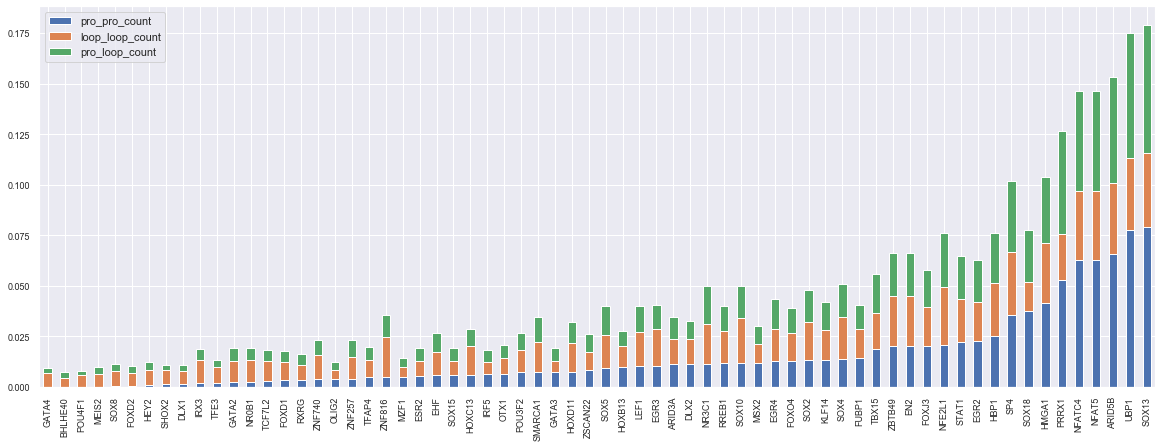

In [27]:
# all tfs
ax = motif_counts_df_norm.sort_values('pro_pro_count').plot(kind='bar', stacked=True,figsize = (20,7),fontsize=9)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_diff_config_count_bar.pdf'))


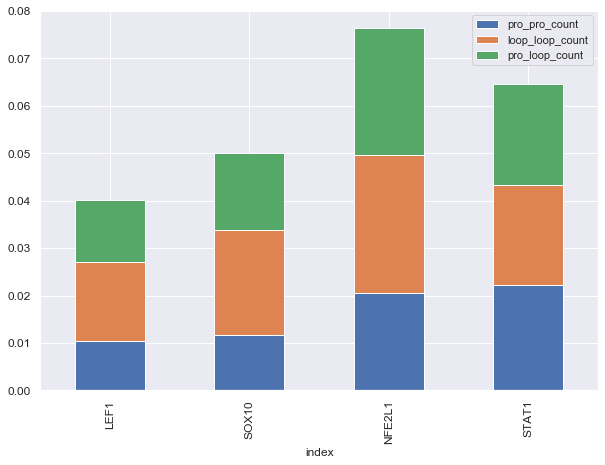

In [28]:
# same graph as before but only for tissue specific TFS

ax = motif_counts_df_norm_sel.sort_values('pro_pro_count').plot(kind='bar', stacked=True,figsize = (10,7),fontsize=12)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_diff_config_count_sel_bar.pdf'))


this shows the likelihood of the motif appears in a vocab pair from pro_pro, pro_loop, or loop_loop configurations, GIVEN that it does appear at all (so normalized by both the probability of the configuration type as well as by the motif frequency itself


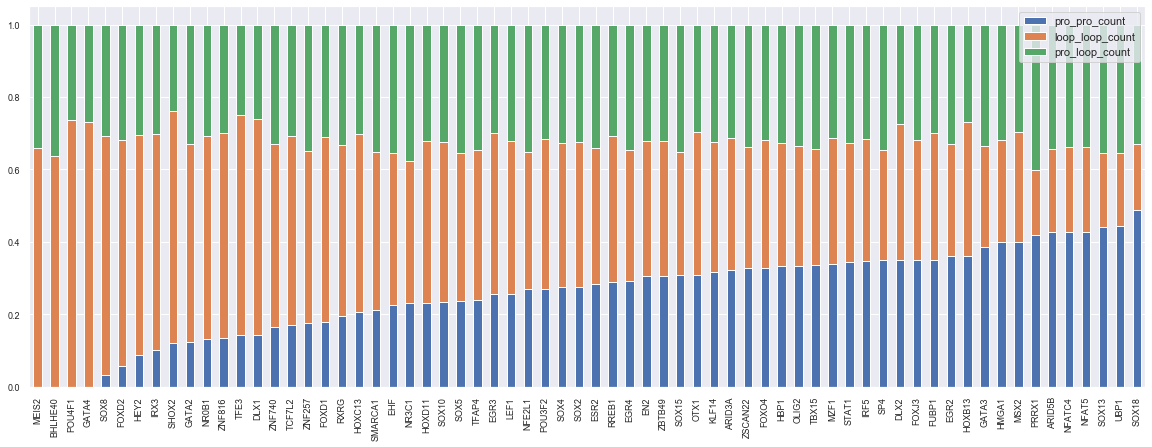

In [29]:
ax = motif_counts_df_norm.div(motif_counts_df_norm.sum(axis=1),axis=0).sort_values('pro_pro_count').plot(kind='bar', stacked=True,
                                                                                                    figsize = (20,7),fontsize=9)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_diff_config_count_norm_bar.pdf'))


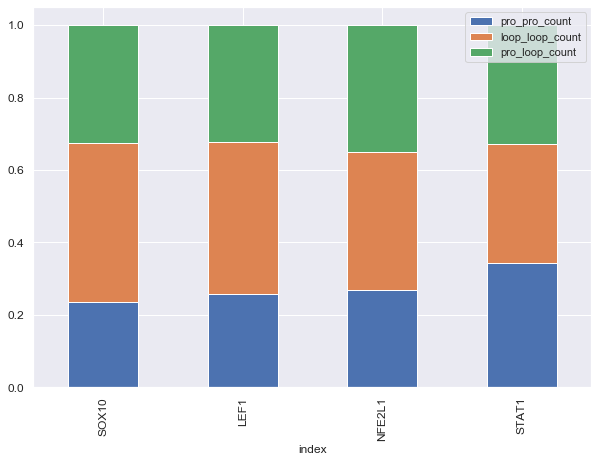

In [30]:
ax = motif_counts_df_norm_sel.div(motif_counts_df_norm_sel.sum(axis=1),axis=0).sort_values('pro_pro_count').plot(kind='bar', stacked=True,
                                                                                                    figsize = (10,7),fontsize=12)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_diff_config_count_norm_sel_bar.pdf'))


## 1b enriched vocab from expressed genes in all scc lines

In [31]:
loop_type_df_1 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_mm/expr_WM-SCR-DMSO_loop_type.csv',index_col=0).fillna('')
loop_type_df_2 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_mm/expr_COLO-SCR-DMSO_loop_type.csv',index_col=0).fillna('')


In [32]:
loop_type_df_all = loop_type_df_1[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]+loop_type_df_2[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]
loop_type_df_all['pro_loop_count'] = loop_type_df_all['pro_loop_count']+ loop_type_df_all['loop_pro_count']
loop_type_df_all = loop_type_df_all[['pro_pro_count','pro_loop_count','loop_loop_count']]
loop_type_df_all[:5]

,pro_pro_count,pro_loop_count,loop_loop_count
ALX4::ARNT,0,0,0
ALX4::ARNTL,0,0,0
ALX4::BATF3,0,0,0
ALX4::CBFB,0,0,0
ALX4::CEBPZ,0,0,0


In [33]:
# for motifs
# 1. get motifs
motifs = set()
for vocab_pair in loop_type_df_all.index.values:
    v1, v2 = vocab_pair.split('::')
    motifs.add(v1)
    motifs.add(v2)
motifs = sorted(motifs)
print(len(motifs))

# 2. initialize counts
motif_counts_dict = {}
for motif in motifs:
    motif_counts_dict[motif] = {'pro_pro_count':0,'loop_loop_count':0,'pro_loop_count':0} #list of counts for pro_pro_count, loop_loop_count, pro_loop_count, respectively
    
# 3. run through loop_type_df to fill in motif_counts_dict
for vocab_pair, row in loop_type_df_all.iterrows():
    v1, v2 = vocab_pair.split('::')
    motif_counts_dict[v1]['pro_pro_count'] +=row['pro_pro_count']
    motif_counts_dict[v2]['pro_pro_count'] +=row['pro_pro_count']
    motif_counts_dict[v1]['loop_loop_count'] +=row['loop_loop_count']
    motif_counts_dict[v2]['loop_loop_count'] +=row['loop_loop_count']
    motif_counts_dict[v1]['pro_loop_count'] +=row['pro_loop_count']
    motif_counts_dict[v2]['pro_loop_count'] +=row['pro_loop_count']
            
motif_counts_df = pd.DataFrame.from_dict(motif_counts_dict,orient='index')   
motif_counts_df_norm = motif_counts_df/motif_counts_df.sum(axis=0)
motif_counts_df_norm_sel = motif_counts_df_norm.reset_index()[motif_counts_df_norm.reset_index()['index'].isin(TFS)]
print(motif_counts_df_norm_sel.shape)
motif_counts_df_norm_sel.set_index('index',inplace=True)

176
(5, 4)


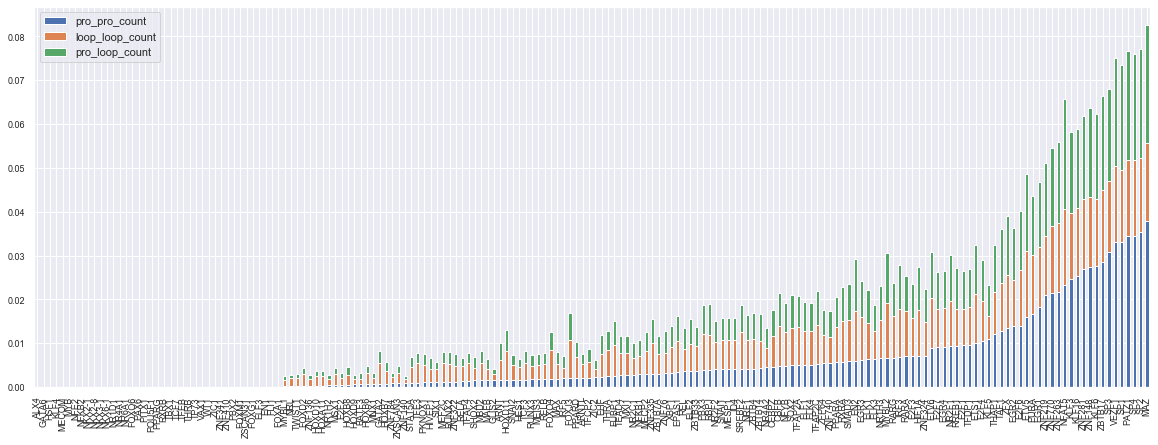

In [34]:
# all tfs
ax = motif_counts_df_norm.sort_values('pro_pro_count').plot(kind='bar', stacked=True,figsize = (20,7),fontsize=9)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_expr_config_count_bar.pdf'))


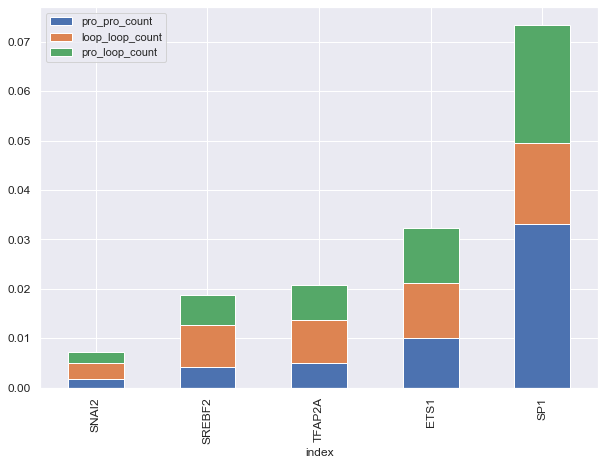

In [35]:
#same graph as before but only for tissue specific TFS

ax = motif_counts_df_norm_sel.sort_values('pro_pro_count').plot(kind='bar', stacked=True,figsize = (10,7),fontsize=12)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_expr_config_count_sel_bar.pdf'))


this shows the likelihood of the motif appears in a vocab pair from pro_pro, pro_loop, or loop_loop configurations, GIVEN that it does appear at all (so normalized by both the probability of the configuration type as well as by the motif frequency itself


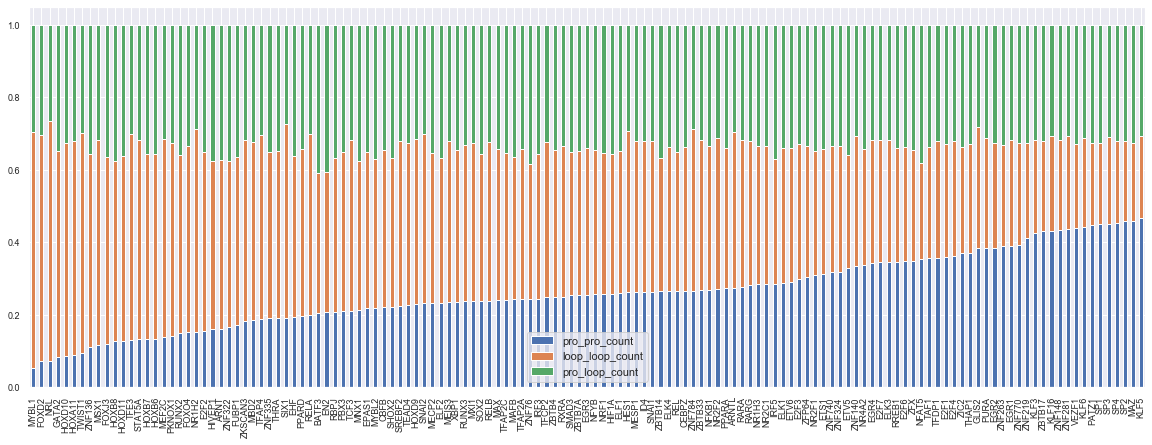

In [45]:
ax = motif_counts_df_norm.div(motif_counts_df_norm.sum(axis=1),axis=0).sort_values('pro_pro_count').dropna().plot(kind='bar', stacked=True,
                                                                                                    figsize = (20,7),fontsize=9)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_expr_config_count_norm_bar.pdf'))


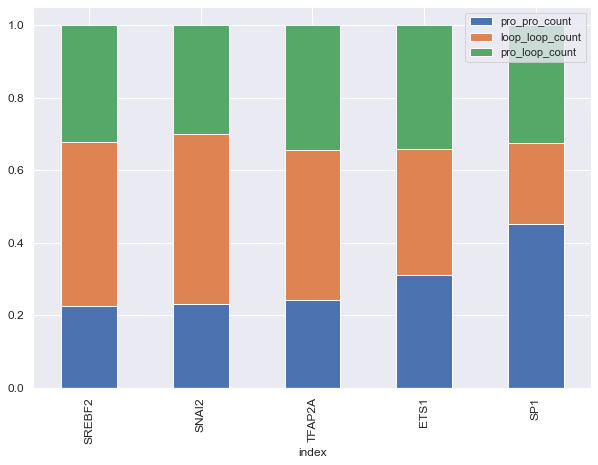

In [46]:
ax = motif_counts_df_norm_sel.div(motif_counts_df_norm_sel.sum(axis=1),axis=0).sort_values('pro_pro_count').plot(kind='bar', stacked=True,
                                                                                                    figsize = (10,7),fontsize=12)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_expr_config_count_norm_sel_bar.pdf'))


# 2. Vocabulary genomic instances - setup


## 2A. find the locations

In [47]:
sorted(glob.glob('../data/processed/fig4_modelling/tf_tf_pairs_scc/'+'*vocab*'))

['../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_A431-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_A431-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_CAL27-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_CAL27-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_SCC13-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_SCC13-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_A431-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_A431-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_CAL27-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_CAL27-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_SCC13-CT

## 2B helper functions

In [48]:
def get_other_vocab_word(row, next_row):
    if row['vocab']!=next_row['vocab']:
        return False
    
    vocab_word = set(row['tf'])
    vocab_set = set(row['vocab'].split('::'))
    other_vocab = list(vocab_set -  vocab_word)[0]
    return other_vocab == next_row['tf']

def check_distance(row,next_row,max_dist=MAX_DIST):
    if row['chr_m']==next_row['chr_m']:
        if row['stop_m']<next_row['start_m']:
            tot_dist = next_row['stop_m'] - row['start_m']
            btn_dist = next_row['start_m'] - row['stop_m']
            return (tot_dist < max_dist), tot_dist, btn_dist
    return False,-1,-1

def check_tissue(row,next_row,tfs=TFS):
    if (row['tf'] in tfs) & (next_row['tf'] in tfs):
        return 'both'
    elif (row['tf'] in tfs) | (next_row['tf'] in tfs):
        return 'one'    
    else:
        return 'none'
    
def get_hits(vocab_file,tfs=TFS):
    print('**** reading', vocab_file)
    vocab_df = pd.read_csv(vocab_file)
    print(vocab_df.shape)
    idx = 0
    idx_hits = 0
    results_dict = {}
    while idx < (vocab_df.shape[0]-1):
        # look at next 
        row = vocab_df.iloc[idx,:]
        next_row = vocab_df.iloc[idx+1,:]

        check_vocab_pair = get_other_vocab_word(row,next_row)
        check_dist,tot_dist, btn_dist = check_distance(row, next_row)
        check_tissue_tf = check_tissue(row,next_row,tfs)
        if (check_dist and check_vocab_pair):
    #         print('hi',idx)
    #         print(row)
    #         print(next_row)

            results_dict[idx_hits] = {'vocab_pair':row['vocab'],'tot_dist':tot_dist,'btn_dist':btn_dist,
                                      'chr':row['chr'],'start':row['start_m'],'stop':next_row['stop_m'], 
                                      'vocab1':row['tf'],'vocab1_start':row['start_m'], 'vocab1_stop': row['stop_m'],
                                      'vocab2':next_row['tf'],'vocab2_start':next_row['start_m'], 'vocab2_stop': next_row['stop_m'],
                                      'genes':row['genes'],'num_genes':len(row['genes'].split('|')), 'tissue':row['tissue'],
                                     'check_tissuetf':check_tissue_tf}
            idx_hits+=1

        idx+=1
    print('num_hits',idx_hits)
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    return results_df
    
def filter_results(results_df,min_hits_per_vocab=10):
    print('shape', results_df.shape)
    vocab_counts = results_df.vocab_pair.value_counts()
    print('original num vocab',vocab_counts.shape[0])
    vocab_to_include = vocab_counts[vocab_counts>min_hits_per_vocab].index.values
    print('filt num vocab',vocab_to_include.shape[0])
    
    results_df_filt = results_df[results_df.vocab_pair.isin(vocab_to_include)]
    return results_df_filt

    

# 3. Vocabulary genomic instances - running

## 3A get expression and stability for loop-loop regions


run through all 3 tissue types

and then 

In [213]:
# ###TESTING PURPOSES
# vocab_df = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD6_pro_pro_vocab_info.csv')
# print(vocab_df.shape)
# vocab_df[:5]
TISSUE = 'COLO-SCR-DMSO'#'WM-SCR-DMSO'#
type_enrich = 'diff_'#'expr_'

In [214]:
%%time
# filtered so that at least 10 genomic instances of vocab pair in significantly found in expressed genes 
results_expr_pro_pro = get_hits('../data/processed/fig4_modelling/tf_tf_pairs_mm/'+type_enrich+TISSUE+'_pro_pro_vocab_info.csv')


**** reading ../data/processed/fig4_modelling/tf_tf_pairs_mm/diff_COLO-SCR-DMSO_pro_pro_vocab_info.csv
(18328, 15)
num_hits 5400
CPU times: user 7.76 s, sys: 23.4 ms, total: 7.78 s
Wall time: 7.79 s


In [215]:
%%time
### TAKES AWHILE
results_expr_loop_loop = get_hits('../data/processed/fig4_modelling/tf_tf_pairs_mm/'+type_enrich+TISSUE+'_loop_loop_vocab_info.csv')


**** reading ../data/processed/fig4_modelling/tf_tf_pairs_mm/diff_COLO-SCR-DMSO_loop_loop_vocab_info.csv
(99627, 15)
num_hits 23406
CPU times: user 42.3 s, sys: 166 ms, total: 42.4 s
Wall time: 42.5 s


## 3B raw statistics (pre genomic instance filter)

In [216]:
motifs_pro_pro = sorted(set(list(results_expr_pro_pro.vocab1.unique())+list(results_expr_pro_pro.vocab2.unique())))
print('num motifs in pro_pro', len(motifs_pro_pro))
print(motifs_pro_pro)


motifs_loop_loop = sorted(set(list(results_expr_loop_loop.vocab1.unique())+list(results_expr_loop_loop.vocab2.unique())))
print('num motifs in loop_loop', len(motifs_loop_loop))
print(motifs_loop_loop)

num motifs in pro_pro 50
['ARID3A', 'ARID5B', 'DLX1', 'DLX2', 'EGR3', 'EN2', 'FOXD1', 'FOXJ3', 'FOXO4', 'FUBP1', 'GATA2', 'GATA3', 'HBP1', 'HMGA1', 'HOXB13', 'HOXC13', 'IRF5', 'IRX3', 'LEF1', 'MSX2', 'MZF1', 'NFAT5', 'NFATC4', 'NFE2L1', 'NR0B1', 'NR3C1', 'OLIG2', 'OTX1', 'POU3F2', 'RREB1', 'RXRG', 'SHOX2', 'SMARCA1', 'SOX10', 'SOX13', 'SOX15', 'SOX18', 'SOX2', 'SOX4', 'SOX5', 'SP4', 'STAT1', 'TCF7L2', 'TFAP4', 'TFE3', 'UBP1', 'ZBTB49', 'ZNF740', 'ZNF816', 'ZSCAN22']
num motifs in loop_loop 55
['ARID3A', 'ARID5B', 'BHLHE40', 'DLX1', 'DLX2', 'EGR3', 'EN2', 'FOXD1', 'FOXD2', 'FOXJ3', 'FOXO4', 'FUBP1', 'GATA2', 'GATA3', 'HBP1', 'HEY2', 'HMGA1', 'HOXB13', 'HOXC13', 'IRF5', 'IRX3', 'LEF1', 'MEIS2', 'MSX2', 'MZF1', 'NFAT5', 'NFATC4', 'NFE2L1', 'NR0B1', 'NR3C1', 'OLIG2', 'OTX1', 'POU3F2', 'RREB1', 'RXRG', 'SHOX2', 'SMARCA1', 'SOX10', 'SOX13', 'SOX15', 'SOX18', 'SOX2', 'SOX4', 'SOX5', 'SOX8', 'SP4', 'STAT1', 'TCF7L2', 'TFAP4', 'TFE3', 'UBP1', 'ZBTB49', 'ZNF740', 'ZNF816', 'ZSCAN22']


In [217]:
print('pre genomic instance filter')
print('num vocab in expression enrichment (pro-pro region): ', results_expr_pro_pro.vocab_pair.unique().shape[0])
print('num vocab in expression enrichment (loop-loop region): ', results_expr_loop_loop.vocab_pair.unique().shape[0])

pre genomic instance filter
num vocab in expression enrichment (pro-pro region):  491
num vocab in expression enrichment (loop-loop region):  948


## 3C. filter expression enriched vocab words if then have at least 10 genomic instances then get stats

In [218]:
results_expr_pro_pro = filter_results(results_expr_pro_pro,min_hits_per_vocab=10)
# print(results_expr_pro_pro.vocab_pair.unique().shape)
# results_expr_pro_pro.vocab_pair.unique()

shape (5400, 16)
original num vocab 491
filt num vocab 129


In [219]:
results_expr_loop_loop = filter_results(results_expr_loop_loop,min_hits_per_vocab=10)
# print(results_expr_loop_loop.vocab_pair.unique().shape)
# results_expr_loop_loop.vocab_pair.unique()

shape (23406, 16)
original num vocab 948
filt num vocab 295


In [220]:
print('post genomic instance filter')
print('num vocab in expression enrichment (pro-pro region): ', results_expr_pro_pro.vocab_pair.unique().shape[0])
print(results_expr_pro_pro.vocab_pair.unique())
print('num vocab in expression enrichment (loop-loop region): ', results_expr_loop_loop.vocab_pair.unique().shape[0])
print(results_expr_loop_loop.vocab_pair.unique())


post genomic instance filter
num vocab in expression enrichment (pro-pro region):  129
['ARID3A::ARID5B' 'ARID3A::SOX13' 'ARID3A::SOX18' 'ARID5B::DLX2'
 'ARID5B::EN2' 'ARID5B::FOXD1' 'ARID5B::FOXJ3' 'ARID5B::FOXO4'
 'ARID5B::FUBP1' 'ARID5B::GATA3' 'ARID5B::HBP1' 'ARID5B::HMGA1'
 'ARID5B::HOXB13' 'ARID5B::HOXC13' 'ARID5B::IRF5' 'ARID5B::LEF1'
 'ARID5B::MSX2' 'ARID5B::MZF1' 'ARID5B::NFAT5' 'ARID5B::NFATC4'
 'ARID5B::NFE2L1' 'ARID5B::NR3C1' 'ARID5B::OTX1' 'ARID5B::RXRG'
 'ARID5B::SMARCA1' 'ARID5B::SOX13' 'ARID5B::SOX18' 'ARID5B::SOX2'
 'ARID5B::SOX4' 'ARID5B::SP4' 'ARID5B::STAT1' 'ARID5B::UBP1'
 'ARID5B::ZBTB49' 'DLX2::SOX13' 'DLX2::SOX18' 'EGR3::NFAT5' 'EGR3::NFATC4'
 'EGR3::SOX13' 'EGR3::SOX18' 'EGR3::SP4' 'EN2::SOX13' 'EN2::SOX18'
 'EN2::UBP1' 'FOXJ3::HMGA1' 'FOXJ3::SOX18' 'FOXO4::SOX13' 'FOXO4::SOX18'
 'FUBP1::SOX13' 'FUBP1::SOX18' 'GATA3::SOX13' 'GATA3::SOX18' 'GATA3::UBP1'
 'HBP1::HMGA1' 'HBP1::SOX13' 'HBP1::SOX18' 'HBP1::SP4' 'HBP1::UBP1'
 'HMGA1::LEF1' 'HMGA1::NFAT5' 'HMGA1::NFATC

## 3D filter expr vocab words based on whether there is they are annotated for skin

In [221]:
results_expr_pro_pro[['vocab_pair','check_tissuetf']].drop_duplicates().check_tissuetf.value_counts()

none    128
one      16
Name: check_tissuetf, dtype: int64

In [222]:
results_expr_loop_loop[['vocab_pair','check_tissuetf']].drop_duplicates().check_tissuetf.value_counts()

none    289
one      28
both      5
Name: check_tissuetf, dtype: int64

shows fraction of vocab words having tissue specific motif configuration (`both` are tissue specific, `one` is tissue specific, or `none` are)


MAKE SURE #s are around 40 ish so pick `one` or `both`

In [223]:
filter_thres = ['one','both'] # 'one'#'none','one',
results_expr_pro_pro_tissue = results_expr_pro_pro[results_expr_pro_pro.check_tissuetf.isin(filter_thres)]
print('pro-pro region')
print('total vocab:',results_expr_pro_pro.vocab_pair.unique().shape[0],'tissue annon vocab:', results_expr_pro_pro_tissue.vocab_pair.unique().shape[0])
print(results_expr_pro_pro_tissue.vocab_pair.unique())

# results_expr_loop_loop_tissue = results_expr_loop_loop[results_expr_loop_loop.check_tissuetf.isin(filter_thres)]
# print('loop-loop region')
# print('total vocab:',results_expr_loop_loop.vocab_pair.unique().shape[0],'tissue annon vocab:', results_expr_loop_loop_tissue.vocab_pair.unique().shape[0])
# print(results_expr_loop_loop_tissue.vocab_pair.unique())

pro-pro region
total vocab: 129 tissue annon vocab: 16
['ARID5B::LEF1' 'ARID5B::NFE2L1' 'ARID5B::STAT1' 'HMGA1::LEF1'
 'HMGA1::NFE2L1' 'HMGA1::STAT1' 'LEF1::SOX13' 'LEF1::SOX18'
 'NFAT5::NFE2L1' 'NFATC4::NFE2L1' 'NFE2L1::SOX13' 'NFE2L1::SOX18'
 'NFE2L1::UBP1' 'SOX13::STAT1' 'SOX18::STAT1' 'STAT1::UBP1']


## 3E add in stability scores vocab pairs that pass the genomic instance filter and get genomic instance counts

In [224]:
def get_counts(results_df, label):
    counts_df = pd.DataFrame(results_df.vocab_pair.value_counts())
    counts_df.columns = ['num_instance']
    counts_df['label']=label
    return counts_df

In [225]:
vocab_summary_df = pd.concat([# get_counts(results_stability_pro_pro, 'stability_pro'),
            get_counts(results_expr_pro_pro_tissue, 'expr_pro_tissue'),
#             get_counts(results_stability_loop_loop, 'stability_loop'),
            get_counts(results_expr_loop_loop_tissue, 'expr_loop_tissue')
        ],
    axis=0)
vocab_summary_df.index.set_names('vocab',inplace=True)
vocab_summary_df.reset_index(inplace=True)
vocab_summary_df = vocab_summary_df.groupby('vocab').agg({'num_instance':sum, 'label':'|'.join}).reset_index()
vocab_summary_df['tissue']=TISSUE
vocab_summary_df.label.value_counts()
# results_stability_loop_loop.vocab_pair.unique()

expr_loop_tissue                    40
expr_pro_tissue|expr_loop_tissue    13
expr_pro_tissue                      3
Name: label, dtype: int64

In [226]:
vocab_summary_df.to_csv(os.path.join(save_dir, TISSUE+'_vocab_summary.csv'))
print('saved:', os.path.join(save_dir, TISSUE+'_vocab_summary.csv'))

saved: ../data/processed/fig4_modelling/vocab_sum/COLO-SCR-DMSO_vocab_summary.csv


# 4. manual run all 3 tissue types

look at the *vocab_summary.csv

manually pair down list to one xlsx

`vocab_sum/scc_filtered_vocab_list.xlsx`



In [227]:
glob.glob( os.path.join(save_dir, '*_vocab_summary.csv'))

['../data/processed/fig4_modelling/vocab_sum/SCC13-CTRLi_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/GM12878_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/COLO-SCR-DMSO_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/MM_all_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/GDSD0_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/A431-CTRLi_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/Melanocytes_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/Colon_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/GDSD6_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/CAL27-CTRLi_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/SCC_all_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/WM-SCR-DMSO_vocab_summary.csv']

In [228]:
mm_df = pd.concat([pd.read_csv('../data/processed/fig4_modelling/vocab_sum/COLO-SCR-DMSO_vocab_summary.csv',index_col=0),
          pd.read_csv('../data/processed/fig4_modelling/vocab_sum/WM-SCR-DMSO_vocab_summary.csv',index_col=0)],axis=0)
mm_df

,vocab,num_instance,label,tissue
0,ARID5B::LEF1,11,expr_pro_tissue|expr_loop_tissue,COLO-SCR-DMSO
1,ARID5B::NFE2L1,44,expr_pro_tissue|expr_loop_tissue,COLO-SCR-DMSO
2,ARID5B::SOX10,21,expr_loop_tissue,COLO-SCR-DMSO
3,ARID5B::STAT1,32,expr_pro_tissue|expr_loop_tissue,COLO-SCR-DMSO
4,EGR2::LEF1,7,expr_loop_tissue,COLO-SCR-DMSO
...,...,...,...,...
48,SP4::STAT1,13,expr_loop_tissue,WM-SCR-DMSO
49,STAT1::TBX15,10,expr_loop_tissue,WM-SCR-DMSO
50,STAT1::UBP1,49,expr_pro_tissue|expr_loop_tissue,WM-SCR-DMSO
51,STAT1::ZBTB49,5,expr_loop_tissue,WM-SCR-DMSO


In [229]:
mm_df_tissue2 = mm_df.groupby('vocab').agg({'tissue': '|'.join,'num_instance':sum, 'label': lambda x: '|'.join(list(set(x)))})
mm_df_tissue2 = mm_df_tissue2[mm_df_tissue2.tissue=='COLO-SCR-DMSO|WM-SCR-DMSO'].reset_index()

In [230]:
mm_df_tissue2['tissue']= 'cancer'
mm_df_tissue2

,vocab,tissue,num_instance,label
0,ARID5B::LEF1,cancer,21,expr_pro_tissue|expr_loop_tissue
1,ARID5B::NFE2L1,cancer,82,expr_pro_tissue|expr_loop_tissue
2,ARID5B::SOX10,cancer,42,expr_loop_tissue
3,ARID5B::STAT1,cancer,59,expr_loop_tissue|expr_pro_tissue|expr_loop_tissue
4,EGR2::LEF1,cancer,14,expr_loop_tissue
5,EGR2::NFE2L1,cancer,34,expr_loop_tissue
6,EGR2::SOX10,cancer,14,expr_loop_tissue
7,EGR2::STAT1,cancer,16,expr_loop_tissue
8,EGR4::NFE2L1,cancer,20,expr_loop_tissue
9,EGR4::STAT1,cancer,8,expr_loop_tissue


In [231]:
mm_df_tissue2.to_csv( os.path.join(save_dir, 'MM_all_vocab_summary.csv'))

In [232]:
len(set(mm_df_tissue2.vocab.values))

53

In [233]:
# compare to those from GDSD6

In [234]:
normal_df = pd.read_csv('../data/processed/fig4_modelling/vocab_sum/Melanocytes_vocab_summary.csv',index_col=0)

In [235]:
normal_df

,vocab,num_instance,label,tissue
0,ALX1::PRRX1,64,expr_loop_tissue,Melanocytes
1,ARNT2::EN2,32,expr_pro_tissue|expr_loop_tissue,Melanocytes
2,ARNT2::ETV2,12,expr_loop_tissue,Melanocytes
3,ARNT2::IRF4,12,expr_loop_tissue,Melanocytes
4,ARNT2::KLF15,99,expr_pro_tissue|expr_loop_tissue,Melanocytes
...,...,...,...,...
103,SP2::TFAP2B,390,expr_pro_tissue|expr_loop_tissue,Melanocytes
104,SP2::ZNF324,182,expr_pro_tissue|expr_loop_tissue,Melanocytes
105,TFAP2B::ZNF219,57,expr_pro_tissue|expr_loop_tissue,Melanocytes
106,TFAP2B::ZNF589,101,expr_pro_tissue|expr_loop_tissue,Melanocytes


In [236]:
set(mm_df_tissue2.vocab.values).intersection(set(normal_df.vocab.values))

{'PRRX1::SOX10'}

removed intersection of normal and cnacer types and shrink list down to 40

TypeError: savefig() missing 1 required positional argument: 'fname'

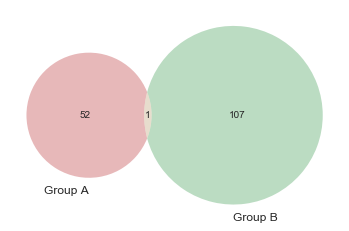

In [237]:
from matplotlib_venn import venn2

 
# Second way
fig = plt.figure()
plt.rcParams['figure.facecolor'] = 'white'

venn2([set(mm_df_tissue2.vocab.values), set(normal_df.vocab.values)],set_labels = ('Group A', 'Group B'))
plt.savefig()
